## E.Dinnne model

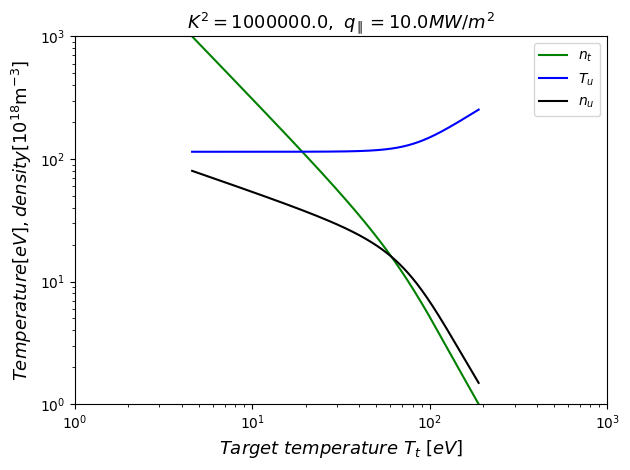

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

@nb.jit
def find_qt(nt, K2, gamma_hat, q):
    qt_init = q-1000.0 #arbitrary
    qt_guess = qt_init
    Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
    Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
    qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
    
    N = 1
    #print(qt_guess - qt_new, qt_new - q)
    while (np.abs(qt_guess - qt_new) > 1e-14) and (N < 1000):
        qt_guess = qt_new
        Tt_guess = np.power((qt_guess/gamma_hat/(nt*1e18)), 2/3)/e
        Tu_guess = np.power((np.power(Tt_guess, 7/2) + 3.5*qt_guess*Lz/a + (63/44)*(np.power(Tt_guess,2) * Lz * a * K2)/qt_guess)/((9/11) + (2*q)/(11*qt_guess)),2/7)
        qt_new = q + (7/4)*a*K2*Lz*(np.power(Tu_guess, 2) - np.power(Tt_guess,2))/(np.power(Tu_guess, 3.5) - np.power(Tt_guess,3.5))
        #print(qt_guess - qt_new, qt_new - q)
        N += 1
    
    return qt_new, Tt_guess, Tu_guess

@nb.jit
def get_results(nt, K2, gamma_hat, q):
    qt = np.zeros_like(nt)
    Tt = np.zeros_like(nt)
    Tu = np.zeros_like(nt)

    for i in range(0,len(nt)):
        qt[i], Tt[i], Tu[i] = find_qt(nt[i], K2, gamma_hat, q)

    nu = 2*nt*Tt/Tu

    return Tt, Tu, nu, qt

a = 2.0e3 # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]
K_sqr = 1e6

N = int(1e4)

nt = np.logspace(0, 3, N)
qt = np.zeros((8, N))
Tt = np.zeros((8, N))
Tu = np.zeros((8, N))
nu = np.zeros((8, N))

Tt, Tu, nu, qt = get_results(nt, K_sqr, gamma_hat, heat_flux)
Tt_2pt, Tu_2pt, nu_2pt, qt_2pt = get_results(nt, 0, gamma_hat, heat_flux)


# x-axis = (1)nt (2)Tt (3)Tu
plot = 2
if plot == 1:
    plt.loglog(nt, Tt, color = 'r', label = f'$T_t$')
    plt.loglog(nt, Tu, color = 'b', label = f'$T_u$')
    plt.loglog(nt, nu, color = 'black', label = f'$n_u$')
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Target\ density\ n_t\ [$10^{18}$m$^{-3}$]$', fontsize = 13)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()
elif plot == 2:
    plt.loglog(Tt, nt, color = 'g', label = f'$n_t$')
    plt.loglog(Tt, Tu, color = 'b', label = f'$T_u$')
    plt.loglog(Tt, nu, color = 'black', label = f'$n_u$')
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Target\ temperature\ T_t\ [eV]$', fontsize = 13)
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()
elif plot == 3:
    plt.loglog(Tu, nt, color = 'r', label = f'$n_t$')
    plt.loglog(Tu, Tt, color = 'b', label = f'$T_t$')
    plt.loglog(Tu, nu, color = 'black', label = f'$n_u$')
    plt.ylabel("$Temperature [eV], density [10^{18}$m$^{-3}]$", fontsize = 13)
    plt.xlabel('$Upstream\ temperature\ T_u\ [eV]$', fontsize = 13)
    plt.ylim(1, 1e3)
    plt.xlim(1, 1e3)
    plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
    plt.legend()
    plt.tight_layout()
    plt.show()


## First solver: f mapping and solve_bvp

Numerical solution calculation time = 1.117583 s
The algorithm converged to the desired accuracy. Used nodes =  20004
Check Neumann BC (f_prime(0)): Error =  0.0
Check Dirichlet BC (f(L)): Error =  0.0
Dinne model: T_u =  114.5687111747721  T_t =  4.584136266409187
ODE Solution: T_u =  89.1897891157522  T_t =  4.584136266409186


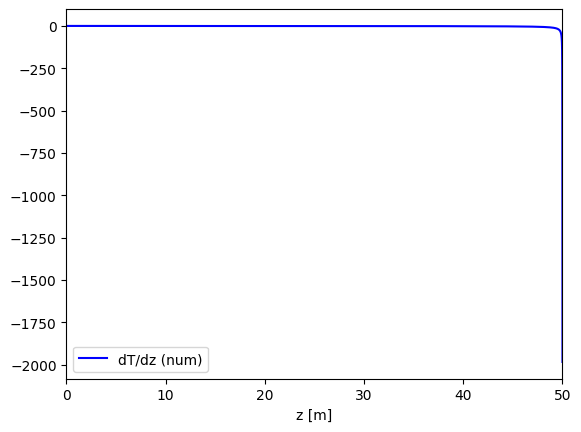

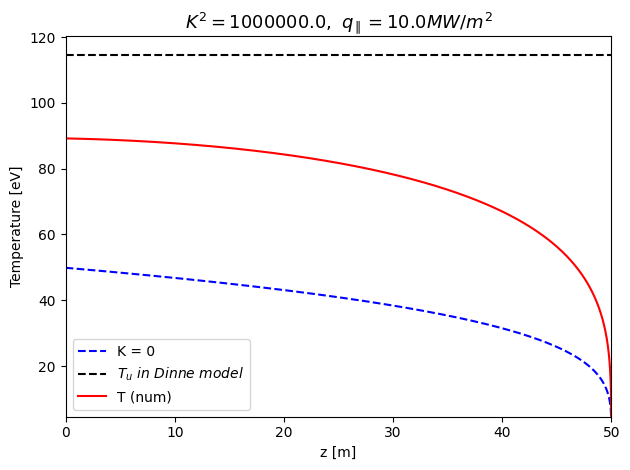

In [13]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import time

@nb.jit
def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return [df_dz, dy2_dz]

@nb.jit
def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz): #Linear guess
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

N = int(1e4)
z_arr = np.linspace(0, Lz, int(1e4))
T_arr = np.zeros((N))
dT_arr = np.zeros((N))
index = -1

start_time = time.time()
f_Z = 2/7 * Tt[index]**(7/2) # f(Z) = f(T_t)
df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
y_ini = ini_guess(Tt[index], z_arr, Lz)
solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-3)

T_arr = (7/2 * solution.y[0])**(2/7)
dT_arr = solution.y[1]/(T_arr**(5/2))
end_time = time.time()
print(f'Numerical solution calculation time = {(end_time - start_time):.6f} s')
print(solution.message, 'Used nodes = ', solution.x.size)

print('Check Neumann BC (f_prime(0)): Error = ', abs(solution.y[1][0] - df0_dz))
print('Check Dirichlet BC (f(L)): Error = ', abs(solution.y[0][-1] - f_Z))

print('Dinne model:', 'T_u = ', Tu[index], ' T_t = ', Tt[index])
print('ODE Solution:', 'T_u = ', T_arr[0], ' T_t = ', T_arr[-1])

#plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, Lz, solution.x.size), dT_arr, color = 'b', label = 'dT/dz (num)')
plt.xlim(0, Lz)
plt.xlabel('z [m]', fontsize = 10)
plt.legend(fontsize = 10)

#plt.subplot(1, 2, 2)
plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_\parallel = {heat_flux/1e6} MW/m^2$', fontsize = 13)
plt.plot(z_arr, (7/2 * y_ini[0])**(2/7), color = 'b', linestyle = '--', label = 'K = 0')
plt.plot([0, Lz], [Tu[index], Tu[index]], '--', color = 'black', label = '$T_u\ in\ Dinne\ model$')

plt.plot(np.linspace(0, Lz, solution.x.size), T_arr, color = 'r', label = 'T (num)')
plt.xlabel('z [m]', fontsize = 10)
plt.ylabel('Temperature [eV]', fontsize = 10)
#plt.ylabel('f', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(Tt[index],)
plt.xlim(0, Lz)
plt.tight_layout()
plt.show()

## Visulization of First solver

Standard model calculation time = 0.360905 s
Numerical solution calculation time = 0.755871 s


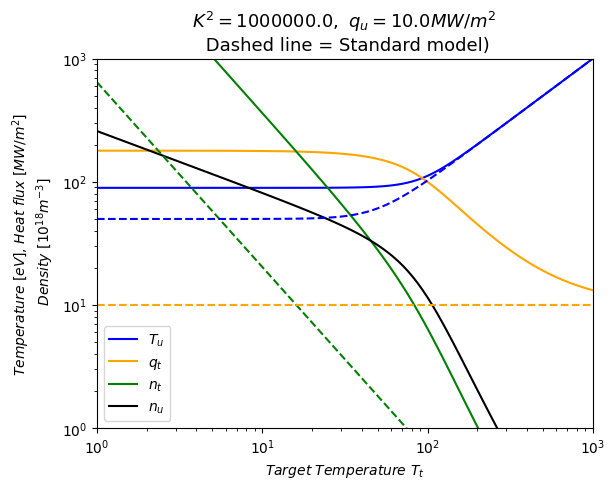

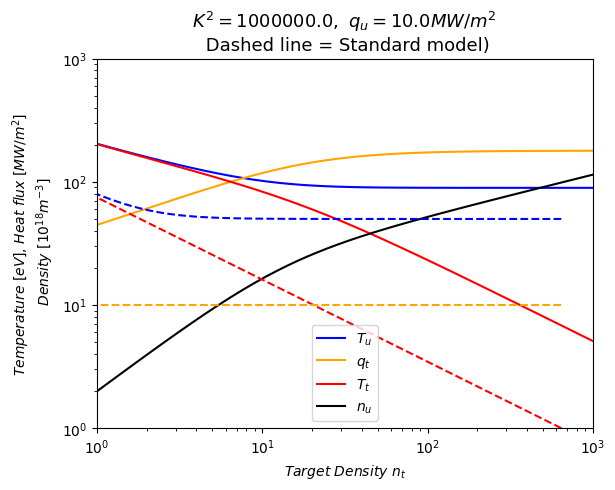

In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import time

def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return np.array([df_dz, dy2_dz])

def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz):
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
a = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27# [kg] 
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]

N = int(1e2)
z_arr = np.linspace(0, Lz, int(1e2))
K_sqr = 0
Tt_0 = np.logspace(0, 3, N)
ft_0 = (2/7) * Tt_0**(7/2)
Tu_0 = np.zeros(N)
qt_0 = np.zeros(N)
nt_0 = np.zeros(N)
nu_0 = np.zeros(N)
fu_0 = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_0[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-6)
    fu_0[index] = solution.y[0][0]
    Tu_0[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_0[index] = np.sqrt(K_sqr * a**2 * (Tu_0[index]**2 - Tt_0[index]**2) + heat_flux**2)
    nt_0[index] = qt_0[index] / (gamma_hat * (e * Tt_0[index])**(3/2) * 1e18)
nu_0 = 2*nt_0*Tt_0/Tu_0
end_time = time.time()
print(f'Standard model calculation time = {(end_time - start_time):.6f} s')

N = int(1e2)
K_sqr = 1e6
z_arr = np.linspace(0, Lz, int(1e2))
Tt_arr = np.logspace(0, 3, N)
ft_arr = (2/7) * Tt_arr**(7/2)
Tu_arr = np.zeros(N)
qt_arr = np.zeros(N)
nt_arr = np.zeros(N)
nu_arr = np.zeros(N)
fu_arr = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_arr[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-4)
    fu_arr[index] = solution.y[0][0]
    Tu_arr[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_arr[index] = np.sqrt(K_sqr * a**2 * (Tu_arr[index]**2 - Tt_arr[index]**2) + heat_flux**2)
    nt_arr[index] = qt_arr[index] / (gamma_hat * (e * Tt_arr[index])**(3/2) * 1e18)
nu_arr = 2*nt_arr*Tt_arr/Tu_arr
end_time = time.time()
print(f'Numerical solution calculation time = {(end_time - start_time):.6f} s')

plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Standard model)', fontsize = 13)
plt.loglog(Tt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(Tt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(Tt_arr, nt_arr, color = 'g', label = '$n_t$')
plt.loglog(Tt_arr, nu_arr, color = 'black', label = '$n_u$')

plt.loglog(Tt_0, nt_0, color = 'g', linestyle = '--')
plt.loglog(Tt_0, Tu_0, color = 'b', linestyle = '--')
plt.loglog(Tt_0, nu_0, color = 'black', linestyle = '--')
plt.loglog(Tt_0, qt_0/1e6, color = 'orange', linestyle = '--')
plt.xlabel('$Target\ Temperature\ T_t$', fontsize = 10)
plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()

plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Standard model)', fontsize = 13)
plt.loglog(nt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(nt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(nt_arr, Tt_arr, color = 'r', label = '$T_t$')
plt.loglog(nt_arr, nu_arr, color = 'black', label = '$n_u$')
plt.loglog(nt_0, Tt_0, color = 'r', linestyle = '--')
plt.loglog(nt_0, Tu_0, color = 'b', linestyle = '--')
plt.loglog(nt_0, nu_0, color = 'black', linestyle = '--')
plt.loglog(nt_0, qt_0/1e6, color = 'orange', linestyle = '--')
plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.xlabel('$Target\ Density\ n_t$', fontsize = 10)
plt.legend(fontsize = 10)
plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()

1.1981402347355923
[1.         0.69780018]
Mean sqr diff =  3.16531044180901
Reliablility? =  0.018072792253719383
Mean sqr diff =  1.6325649437693779
Reliablility? =  0.009321362821078172


/tmp/ipykernel_714/1173854983.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance = curve_fit(func, x, y,maxfev=int(1e9), ftol=1e-15, xtol=1e-15)


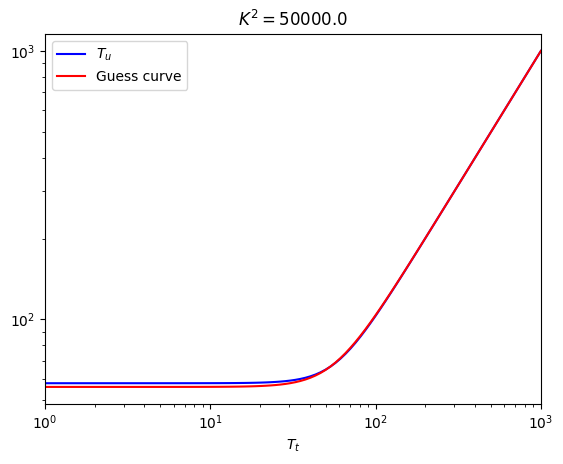

In [10]:
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_func
import numpy as np
import matplotlib.pyplot as plt

varpi = gamma_func(1/4)**2 / (2 * np.sqrt(2*np.pi)) #3/5 * np.pi/varpi = 0.72
x = Tt_arr**(7/2)
y = Tu_arr**(7/2)
Const = 7/2 * heat_flux*Lz/a

def func(x, C1, C2):
    #return x + Const + ((np.sqrt(K_sqr) * Lz / (3/5 * np.pi/varpi))**(7/5))**C2
    return x + (Const**(10/7) + (K_sqr * Lz**2 / (3/5 * np.pi/varpi)**2))**C2

print(np.pi/varpi)
params, params_covariance = curve_fit(func, x, y,maxfev=int(1e9), ftol=1e-15, xtol=1e-15)
print(params)
plt.title(f'$K^2 = {K_sqr}$')
plt.loglog(Tt_arr, y**(2/7), label="$T_u$", color = 'b')
#plt.loglog(Tt_arr, func(x, params[0], params[1])**(2/7), label=f"Fitted curve", color='orange')
msd = np.mean((y**(2/7) - func(x, params[0], params[1])**(2/7))**2)
print('Mean sqr diff = ', msd)
print('Reliablility? = ', msd/np.mean(Tu_arr))
guess = np.array([26, 0.7])
plt.loglog(Tt_arr, func(x, guess[0], guess[1])**(2/7), label=f"Guess curve", color='r')
msd = np.mean((y**(2/7) - func(x, guess[0], guess[1])**(2/7))**2)
print('Mean sqr diff = ', msd)
print('Reliablility? = ', msd/np.mean(Tu_arr))
plt.xlabel('$T_t$')
#plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.legend()
plt.show()

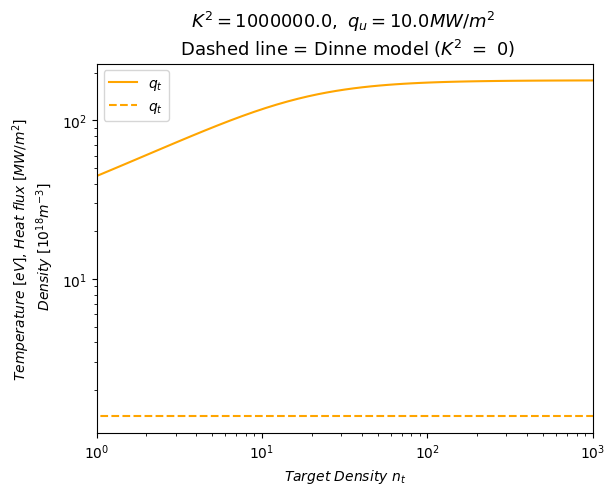

In [ ]:
plt.figure()
plt.title(f'$K^2 = {K_sqr},\ q_u = {heat_flux/1e6} MW/m^2$ \n Dashed line = Dinne model ($K^2\ =\ {K_D}$)', fontsize = 13)
#plt.loglog(nt_arr, Tu_arr, color = 'b', label = '$T_u$')
plt.loglog(nt_arr, qt_arr/1e6, color = 'orange', label = '$q_t$')
plt.loglog(nt_arr, qt_guess/1e6, color = 'orange', label = '$q_t$', linestyle = '--')

#plt.loglog(nt_arr, Tt_arr, color = 'r', label = '$T_t$')
#plt.loglog(nt_arr, nu_arr, color = 'black', label = '$n_u$')
#plt.loglog(nt, Tu, color = 'b', linestyle = '--')
#plt.loglog(nt, Tt, color = 'r', linestyle = '--')
#plt.loglog(nt, Tt+Lz*heat_flux/a, color = '#39C5BB', linestyle = '--')

plt.ylabel('$Temperature\ [eV]$, $Heat\ flux\ [MW/m^2]$ \n $Density\ [10^{18}m^{-3}]$', fontsize = 10)
plt.xlabel('$Target\ Density\ n_t$', fontsize = 10)
plt.legend(fontsize = 10)
#plt.ylim(1, 1e3)
plt.xlim(1, 1e3)
plt.show()


+ Sheath potential

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.integrate import simpson
import time

def ode(z, y):
    f = y[0] # y1 = f
    df_dz = y[1] # y2 = df/dz
    dy2_dz = -K_sqr * (7/2 * f)**(-3/7)
    return np.array([df_dz, dy2_dz])

def BC(ya, yb):
    return np.array([yb[0] - f_Z, ya[1] - df0_dz])

@nb.jit
def ini_guess(f_t, z_arr, Lz):
    guess_arr = np.ones((2, z_arr.size))
    guess_arr[0, :] = f_t + heat_flux / a * (Lz - z_arr)
    guess_arr[1, :] = heat_flux / (-a)
    return guess_arr

#@nb.jit
def integration(x, y):
    delta_x = np.diff(x)
    #return np.trapz(y, delta_x)
    #return simpson(y = y, x = delta_x) # Slower
    return np.sum((y[:-1] + y[1:]) / 2 * delta_x)

epsilon0 = 8.8541878188e-12
me = 9.1093837015e-31
coulomb_log = 13
a = 9.6 * ((2 * np.pi)**(3/2) * epsilon0**2) / (me**(1/2) * e**(1/2) * coulomb_log) # [W/m eV^-7/2]
Lz = 50.0 # [m]
m = 1.67e-27 # [kg] (Deuterium: 3.34358372e-27)
m_i = m
m_e = 9.10938356e-31 # [kg]
gamma_hat = 7.0 * np.sqrt(2/m)
e = 1.60218e-19 # [C]
heat_flux = 1e7 # [W/m2]

N = int(1e2)
z_arr = np.linspace(0, Lz, int(1e2))
K_sqr = 0
Tt_0 = np.logspace(0, 3, N)
ft_0 = (2/7) * Tt_0**(7/2)
Tu_0 = np.zeros(N)
qt_0 = np.zeros(N)
nt_0 = np.zeros(N)
nu_0 = np.zeros(N)
fu_0 = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_0[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-6)
    fu_0[index] = solution.y[0][0]
    Tu_0[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_0[index] = np.sqrt(K_sqr * a**2 * (Tu_0[index]**2 - Tt_0[index]**2) + heat_flux**2)
    nt_0[index] = qt_0[index] / (gamma_hat * (e * Tt_0[index])**(3/2) * 1e18)
nu_arr = 2*nt_0*Tt_0/Tu_0
V_sf0 = 1/2 * np.log(2* np.pi* m_e/m_i * (1 + 1)) * Tt_0 #* kT_e[K]/e
end_time = time.time()
print(f'Standard model calculation time = {(end_time - start_time):.6f} s')

N = int(1e2)
K_sqr = 1e6
z_arr = np.linspace(0, Lz, int(1e4))
Tt_arr = np.logspace(0, 3, N)
ft_arr = (2/7) * Tt_arr**(7/2)
delta_z = np.diff(z_arr)
T_arr = np.zeros(N)
R_arr = np.zeros(N)
Tu_arr = np.zeros(N)
qt_arr = np.zeros(N)
nt_arr = np.zeros(N)
nu_arr = np.zeros(N)
fu_arr = np.zeros(N)

start_time = time.time()
for index in range(N):
    f_Z = 2/7 * Tt_arr[index]**(7/2) # f(Z) = f(T_t)
    df0_dz = heat_flux / (-a) # df(Z)/dz = f(q_u)
    y_ini = ini_guess(f_Z, z_arr, Lz)
    solution = solve_bvp(ode, BC, z_arr, y_ini, max_nodes = 1e6, tol = 1e-3)
    z_arr = np.linspace(0, Lz, solution.x.size)
    R_arr[index] = integration(z_arr, ((7/2 * solution.y[0])**(2/7))**(-3/2))
    fu_arr[index] = solution.y[0][0]
    Tu_arr[index] = (7/2 * solution.y[0][0])**(2/7)
    qt_arr[index] = np.sqrt(K_sqr * a**2 * (Tu_arr[index]**2 - Tt_arr[index]**2) + heat_flux**2)
    nt_arr[index] = qt_arr[index] / (gamma_hat * (e * Tt_arr[index])**(3/2) * 1e18)
nu_arr = 2*nt_arr*Tt_arr/Tu_arr
V_sf = 1/2 * np.log(2* np.pi* m_e/m_i * (1 + 1)) * Tt_0 #* kT_e[K]/e
end_time = time.time()
print(f'Numerical solution calculation time = {(end_time - start_time):.6f} s')

sigma_hat = a * 0.6125
deltaq_arr = qt_arr - heat_flux
R_arr = R_arr / sigma_hat

Standard model calculation time = 0.714728 s
Numerical solution calculation time = 408.508694 s
